# Problem B: Effective thermal conductivity of 2-phase materials
Predicting the effective thermal conductivity $k_{\text{eff}}$ of a two-phase composite material is a classical and practical problem in materials science. The goal is to estimate the bulk conductivity of a heterogeneous material made of two constituents with thermal conductivities $k_1$ and $k_2$. One efficient way to compute the effective thermal conductivity of given 2-phase materials is through numerical homogenization.

In numerical homogenization, we need to solve the steady-state heat equation on a representative volume element (RVE): 
$$
-\nabla\cdot(k(x,y)\nabla T) = 0,\quad (x,y)\in\Omega=[0,1]^2 \tag{2}
$$
With the following boundary conditions:
  - $T(x=0,y)=0,\ T(x=1,y)=1 $
  - $\frac{\partial T}{\partial \vec{n}}(x,y=0)=\frac{\partial T}{\partial \vec{n}}(x,y=1)=0$

where $T(x,y)$ indicates the temperature  and $k(x,y)$ indicates thermal conductivity, which is defined piecewise:
$$
k(x,y)=
\begin{cases}
k_1=2.,\quad (x,y)\in\Omega_1\\
k_2=10.,\quad (x,y)\in\Omega_2
\end{cases}
$$
where $\Omega_1$, $\Omega_2$ denote the first phase region and the second phase region, respectively.

<!-- To compute the effective thermal conductivity in the $x$-direction, one can follow the steps:
- **Step 1:** Solve the following PDE:
    $$
    -\nabla\cdot(k(x,y)\nabla T) = 0,\quad (x,y)\in\Omega=[0,1]^2 \tag{3}
    $$
  With boundary conditions:
  - $T(x=0,y)=0,\ T(x=1,y)=1 $
  - $\frac{\partial T}{\partial \vec{n}}(x,y=0)=\frac{\partial T}{\partial \vec{n}}(x,y=1)=0$ 
- **Step 2:** Compute the **average heat flux:**
    $$
    <q> = \frac{1}{|\Omega|}\int_{\Omega}q~d\Omega
    $$
  where $q(x,y)=-k(x,y)\partial_x T$, and the **average temperature gradient:**
    $$
    <\partial_x T> =  \frac{1}{|\Omega|}\int_{\Omega}\partial_x T~d\Omega
    $$
- **Step 3:** Compute the **effective thermal conductivity (in $x$-direction):**
    $$
    k_{eff} = -\frac{<q>}{<\partial_x T>} = \frac{<k(x,y)\partial_x T>}{<\partial_x T>}
    $$ -->

## Task: predicting the temperature field $T(x,y)$ given 2-phase material $k(x,y)$ 
In this task, we have collected many materials $k(x,y)$ which are sampled from a distribution $\mathcal{A}$. We have also computed the corresponding temperature field $T(x,y)$ through solving the PDE problem $(2)$ with high-precision FEM method. Now, we hope to make a fast prediction of the temperature field $T(x,y)$ (therefore, a fast prediction of the effective conductivity) of a group of materials that are sampled from the same distribution.

### The goals
- Please select a suitable deep learning method for solving this task, and explain the reason for using it
- Report your setups for the implementation, such as network structure, activation function, optimizer (with learning rate), epoch (with batch size), loss weights, and other tricks that are used for improvement.
- Compute the $L^2$ relative error (on testing dataset) at each training epoch and plot the ```Error vs. epcoh``` curve (and report the final error). The $L^2$ relative error between the prediction $\{T^{(j)}_{pred}\}^{N}_{j}$ and the truth $\{T^{(j)}_{true}\}^{N}_j$ is defined as follows:
  $$error = \frac{1}{N}\sum_j\sqrt{\frac{\sum_i|T^{(j)}_{pred}(x_i)-T^{(j)}_{true}(x_i)|^2}{\sum_i|T^{(j)}_{true}(x_i)|^2}}$$
 where $j$ indicates the $j$-th instance.
- Plot the material thermal conductivity, the corresponding predicted solution (and the ground truth reference), and the pointwise absolute error for the first instance in the testing Dataset using separate figures with ```matplotlib```.

### Dataset
The observation and the ground truth references are given in the dataset ```EffectiveConductivity.h5```:
- ```k_train```: size(1000, 36, 36), the collected materials (a $36\times 36$ matrix represents each material)
- ```T_train```: size(1000, 36, 36), the collected temperature field (computed on a $36\times 36$ regular mesh)
- ```k_test```: the materials that we are going to predict their corresponding temperature field (Should not be used for training)
- ```T_test```: the ground truth reference of the temperature field (Should not be used for training)
- ```X```: size(36, 36), the $x$-coordiante of locations where the temperature field computed
- ```Y```: size(36, 36), the $y$-coordiante of locations where the temperature field computed
- Link to dataset: [https://www.kaggle.com/datasets/yhzang32/dno4pdes](https://www.kaggle.com/datasets/yhzang32/dno4pdes)

<KeysViewHDF5 ['T_test', 'T_train', 'X', 'Y', 'dTx_test', 'dTx_train', 'k_test', 'k_train']>
The shape of X: torch.Size([36, 36]) The shape of Y: torch.Size([36, 36])
The shape of k_train: torch.Size([1000, 36, 36])
The shape of T_train: torch.Size([1000, 36, 36])
The shape of k_test: torch.Size([200, 36, 36])
The shape of T_test: torch.Size([200, 36, 36])


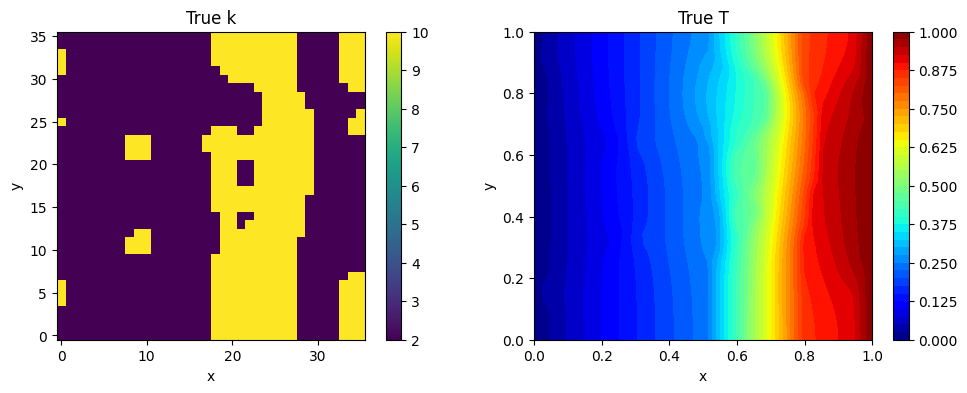

In [1]:
import numpy as np
import h5py
import torch 
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
device = 'cpu'
dtype = torch.float32
######################################
# Load training data
######################################
with h5py.File('EffectiveConductivity.h5', 'r') as data:
    print(data.keys())
    k_train = torch.tensor(np.array(data["k_train"]), dtype=dtype); k_train[k_train==0]=2.; k_train[k_train==1]=10.
    T_train = torch.tensor(np.array(data["T_train"]), dtype=dtype)
    k_test = torch.tensor(np.array(data["k_test"]), dtype=dtype); k_test[k_test==0]=2.; k_test[k_test==1]=10.
    T_test =torch.tensor( np.array(data["T_test"]), dtype=dtype)
    # The coordinates
    X = torch.tensor(np.array(data['X']), dtype=dtype)
    Y = torch.tensor(np.array(data['Y']), dtype=dtype)
print('The shape of X:', X.shape, 'The shape of Y:', Y.shape)
print('The shape of k_train:', k_train.shape)
print('The shape of T_train:', T_train.shape)
print('The shape of k_test:', k_test.shape)
print('The shape of T_test:', T_test.shape)

####### Visualize the training data 
k_show, T_show = k_train[0], T_train[0]
#
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))
#
cntr0 = axs.flat[:][0].imshow(k_show, origin='lower')
fig.colorbar(cntr0, ax=axs.flat[:][0])
axs.flat[:][0].set_title('True k')
axs.flat[:][0].set_xlabel('x')
axs.flat[:][0].set_ylabel('y')
#
cntr1 = axs.flat[:][1].contourf(X, Y, T_show, levels=40, cmap='jet')
fig.colorbar(cntr1, ax=axs.flat[:][1])
axs.flat[:][1].set_title('True T')
axs.flat[:][1].set_xlabel('x')
axs.flat[:][1].set_ylabel('y')
#
plt.show()

In [2]:
!pip install tqdm

  Using cached tqdm-4.67.1-py3-none-any.whl.metadata (57 kB)
Using cached tqdm-4.67.1-py3-none-any.whl (78 kB)


In [1]:
import time
import h5py
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
from tqdm import trange
import matplotlib.pyplot as plt

In [2]:
class DeepONet(nn.Module):
    def __init__(self, in_trunk, in_branch, width_trunk=128, depth_trunk=4, width_branch=128, depth_branch=4):
        super().__init__()
        act = nn.ReLU
        self.trunk = nn.Sequential(*(
            [nn.Linear(in_trunk, width_trunk), act()] +
            [layer for _ in range(depth_trunk - 1)
             for layer in (nn.Linear(width_trunk, width_trunk), act())]
        ))
        self.branch = nn.Sequential(*(
            [nn.Linear(in_branch, width_branch), act()] +
            [layer for _ in range(depth_branch - 1)
             for layer in (nn.Linear(width_branch, width_branch), act())]
        ))
        self.bias = nn.Parameter(torch.zeros(1))
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, a=0.0, nonlinearity="relu")
                nn.init.zeros_(m.bias)

    def forward(self, x, a):
        return (self.trunk(x) * self.branch(a)).sum(-1) + self.bias


In [3]:
class EffectiveDataset(Dataset):
    def __init__(self, k, coords, T=None, dTx=None):
        self.k = k.reshape(len(k), -1).astype(np.float32)
        self.coords = coords.astype(np.float32)
        self.T = None if T is None else T.reshape(len(k), -1).astype(np.float32)
        self.dTx = None if dTx is None else dTx.reshape(len(k), -1).astype(np.float32)
        self.has_labels = self.T is not None

    def __len__(self):
        return len(self.k) * len(self.coords)

    def __getitem__(self, idx):
        sample_idx, coord_idx = divmod(idx, len(self.coords))
        a = self.k[sample_idx]
        x = self.coords[coord_idx]
        
        if self.T is not None and self.dTx is not None:
            return x, a, self.T[sample_idx, coord_idx], self.dTx[sample_idx, coord_idx]
        elif self.T is not None:
            return x, a, self.T[sample_idx, coord_idx]
        else:
            return x, a



In [4]:
def relative_l2(pred, true):
    return torch.linalg.norm(pred - true) / torch.linalg.norm(true)


In [5]:
def train_effective_verbose(data_path, device, epochs=2000, batch_size=4096, lr=1e-3, lam_grad=0.1):
    with h5py.File(data_path, "r") as f:
        k_train, T_train, dTx_train = f["k_train"][:], f["T_train"][:], f["dTx_train"][:]
        k_test,  T_test              = f["k_test"][:],  f["T_test"][:]
        X, Y = f["X"][:], f["Y"][:]

    coords = np.column_stack([X.flatten(), Y.flatten()])
    ds_train = EffectiveDataset(k_train, coords, T_train, dTx_train)
    ds_test  = EffectiveDataset(k_test,  coords, T_test)

    loader_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
    loader_test  = DataLoader(ds_test, batch_size=batch_size)

    model = DeepONet(in_trunk=2, in_branch=1296).to(device)
    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=epochs//3, gamma=0.3)
    mse = nn.MSELoss()

    test_errors = []
    print("Training DeepONet for EffectiveConductivity...")

    start = time.time()
    for ep in trange(epochs):
        model.train()
        for x, a, yT, ydTx in loader_train:
            x, a, yT, ydTx = x.to(device), a.to(device), yT.to(device), ydTx.to(device)
            x.requires_grad_(True)
            out = model(x, a)
            loss_T = mse(out, yT)
            grad = torch.autograd.grad(out, x, grad_outputs=torch.ones_like(out), create_graph=True)[0][:, 0]
            loss_grad = mse(grad, ydTx)
            loss = loss_T + lam_grad * loss_grad

            opt.zero_grad()
            loss.backward()
            opt.step()
        scheduler.step()

        # Fehler auf Testdaten
        model.eval()
        with torch.no_grad():
            preds = [model(x.to(device), a.to(device)).cpu() for x, a, _ in loader_test]
            T_pred = torch.cat(preds).reshape(len(k_test), -1)
            rel_err = relative_l2(T_pred, torch.tensor(T_test.reshape(len(k_test), -1))).item()
            test_errors.append(rel_err)

        if (ep+1) % 200 == 0:
            print(f"Epoch {ep+1:4d} | Rel. L2 Test Error = {rel_err:.3%}")

    end = time.time()
    print(f"\nFinal relative L2 error: {test_errors[-1]:.3%}")
    print(f"Total training time: {end - start:.1f} seconds")

    # Plot Fehler vs. Epoche
    plt.figure(figsize=(8,5))
    plt.plot(range(1, epochs+1), test_errors, label="Test Rel. L2 Error")
    plt.xlabel("Epoch")
    plt.ylabel("Relative L2 Error")
    plt.title("Test Error vs. Epoch")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Save predictions
    with h5py.File("results_effective_verbose.h5", "w") as f:
        f.create_dataset("T_pred", data=T_pred.numpy())

    return model, T_pred.numpy(), T_test, k_test


Training DeepONet for EffectiveConductivity...


100%|██████████████████████████████████████| 50/50 [34:06<00:00, 40.93s/it]


Final relative L2 error: 5.412%
Total training time: 2046.5 seconds


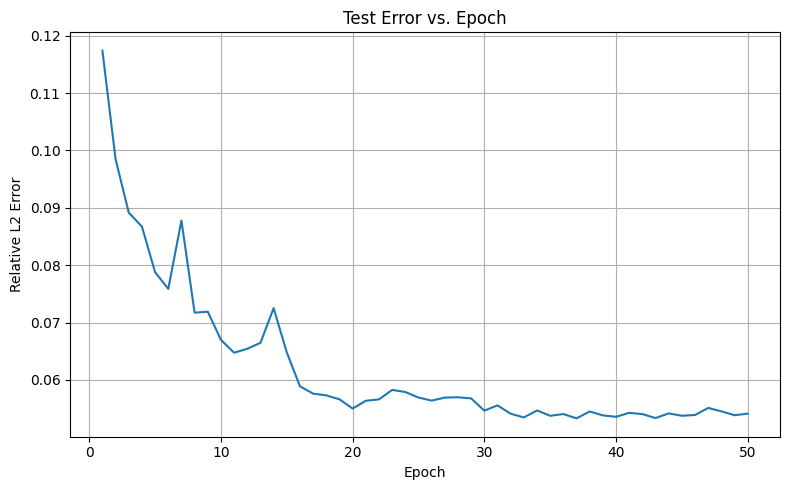

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model, T_pred, T_test, k_test = train_effective_verbose("EffectiveConductivity.h5", device, epochs=50, batch_size=2048)


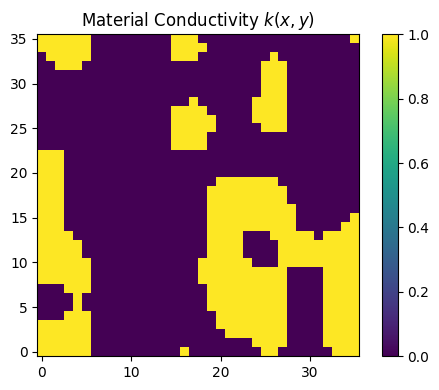

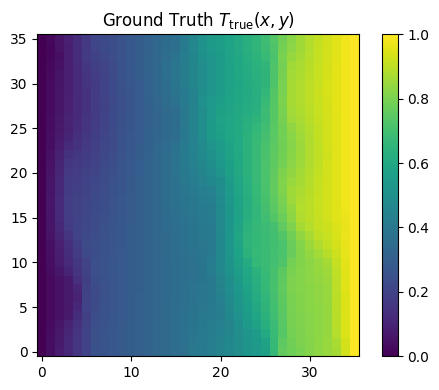

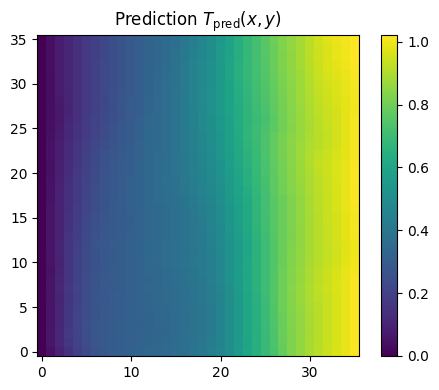

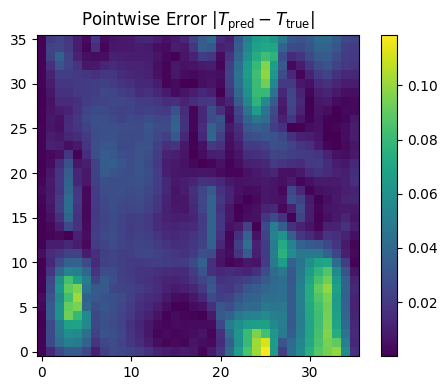

In [30]:
# Plotting für Testbeispiel 0
idx = 0  # Erstes Testbeispiel
N = 36   # Gittergröße

k0 = k_test[idx].reshape(N, N)
T_true0 = T_test[idx].reshape(N, N)
T_pred0 = T_pred[idx].reshape(N, N)
abs_error = np.abs(T_pred0 - T_true0)

# Nur gültige Argumente für imshow!
imshow_kw = dict(cmap='viridis', origin='lower')

titles = [
    "Material Conductivity $k(x,y)$",
    "Ground Truth $T_{\\mathrm{true}}(x,y)$",
    "Prediction $T_{\\mathrm{pred}}(x,y)$",
    "Pointwise Error $|T_{\\mathrm{pred}} - T_{\\mathrm{true}}|$"
]

data = [k0, T_true0, T_pred0, abs_error]

for i, d in enumerate(data):
    plt.figure(figsize=(5, 4))                # figsize gehört hierhin
    im = plt.imshow(d, **imshow_kw)           # kein figsize hier!
    plt.title(titles[i])
    plt.colorbar(im)
    plt.tight_layout()
    plt.show()


Training DeepONet for EffectiveConductivity...


100%|███████████████████████████████████████████████████████████████████████████████| 50/50 [2:34:31<00:00, 185.43s/it]


Final relative L2 error: 4.949%
Total training time: 9271.4 seconds


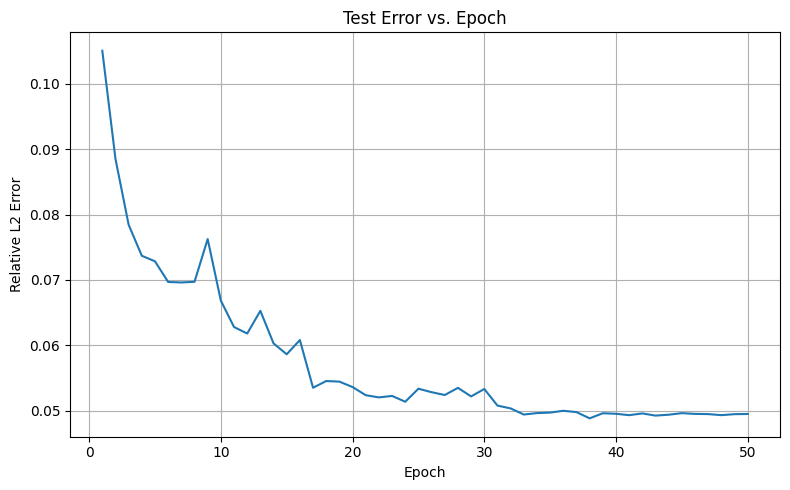

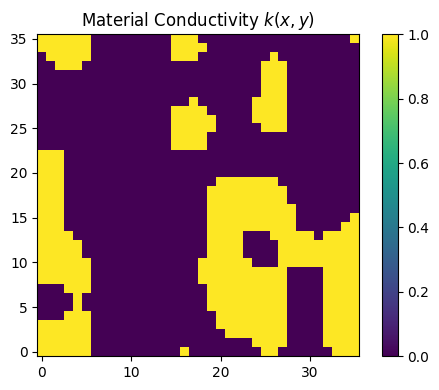

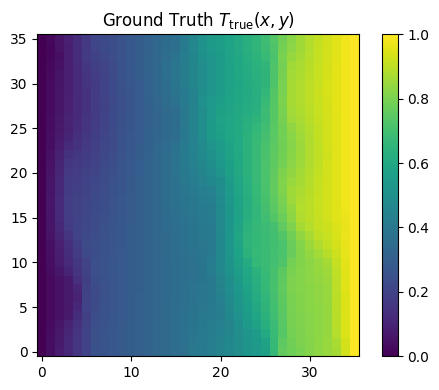

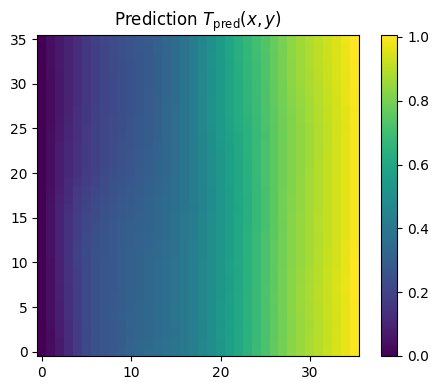

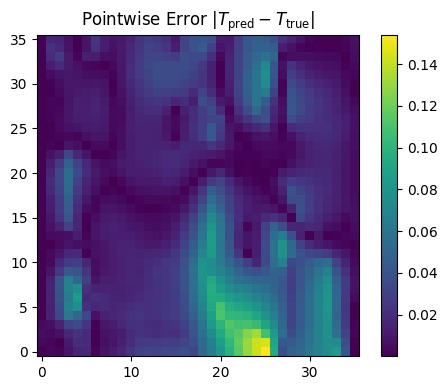

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import numpy as np
import h5py
import time
import matplotlib.pyplot as plt
from tqdm import trange


# Define a Deep Operator Network (DeepONet)

class DeepONet(nn.Module):
    def __init__(self, in_trunk, in_branch, width_trunk=128, depth_trunk=4, width_branch=128, depth_branch=4):
        super().__init__()
        act = nn.ReLU  # ReLU activations

        # The trunk network takes in coordinates (x, y) and learns how the solution behaves spatially
        self.trunk = nn.Sequential(*(
            [nn.Linear(in_trunk, width_trunk), act()] +
            [layer for _ in range(depth_trunk - 1)
             for layer in (nn.Linear(width_trunk, width_trunk), act())]
        ))

        # branch network encodes the input function
        self.branch = nn.Sequential(*(
            [nn.Linear(in_branch, width_branch), act()] +
            [layer for _ in range(depth_branch - 1)
             for layer in (nn.Linear(width_branch, width_branch), act())]
        ))

        # single scalar bias for all outputs
        self.bias = nn.Parameter(torch.zeros(1))

        # Initialize all linear layers
        self._init_weights()

    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.kaiming_normal_(m.weight, a=0.0, nonlinearity="relu")
                nn.init.zeros_(m.bias)

    def forward(self, x, a):
        # multiply outputs from trunk and branch element-wise, then sum to produce a scalar output per sample.
        return (self.trunk(x) * self.branch(a)).sum(-1) + self.bias


# Custom PyTorch Dataset for input to the DeepONet
class EffectiveDataset(Dataset):
    def __init__(self, k, coords, T=None, dTx=None):
        # Reshape input k to [num_samples, num_features]
        self.k = k.reshape(len(k), -1).astype(np.float32)
        self.coords = coords.astype(np.float32)
        

        self.T = None if T is None else T.reshape(len(k), -1).astype(np.float32)
        self.dTx = None if dTx is None else dTx.reshape(len(k), -1).astype(np.float32)
        self.has_labels = self.T is not None 

    def __len__(self):
        # One sample for every (material sample × spatial point) pair
        return len(self.k) * len(self.coords)

    def __getitem__(self, idx):
        # flat index -> (sample, point) pair
        sample_idx, coord_idx = divmod(idx, len(self.coords))
        a = self.k[sample_idx]       # input function
        x = self.coords[coord_idx]   # spatial coordinate
        
        # return data
        if self.T is not None and self.dTx is not None:
            return x, a, self.T[sample_idx, coord_idx], self.dTx[sample_idx, coord_idx]
        elif self.T is not None:
            return x, a, self.T[sample_idx, coord_idx]
        else:
            return x, a


# relative L2 error between prediction and ground truth
def relative_l2(pred, true):
    return torch.linalg.norm(pred - true) / torch.linalg.norm(true)


# Train DeepONet model
def train_effective_verbose(data_path, device, epochs=2000, batch_size=4096, lr=1e-3, lam_grad=0.1):
    # Load dataset from HDF5 file
    with h5py.File(data_path, "r") as f:
        k_train, T_train, dTx_train = f["k_train"][:], f["T_train"][:], f["dTx_train"][:]
        k_test,  T_test              = f["k_test"][:],  f["T_test"][:]
        X, Y = f["X"][:], f["Y"][:]

    # Flatten spatial coordinates into 2D points
    coords = np.column_stack([X.flatten(), Y.flatten()])

    # Prepare training and test datasets
    ds_train = EffectiveDataset(k_train, coords, T_train, dTx_train)
    ds_test  = EffectiveDataset(k_test,  coords, T_test)

    # DataLoaders for batching and shuffling
    loader_train = DataLoader(ds_train, batch_size=batch_size, shuffle=True)
    loader_test  = DataLoader(ds_test, batch_size=batch_size)

    # DeepONet with fixed input sizes
    model = DeepONet(in_trunk=2, in_branch=1296).to(device)

    opt = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=1e-4)
    scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=epochs//3, gamma=0.3)

    mse = nn.MSELoss()  # Standard loss function

    test_errors = []  # Track relative L2 errors across epochs
    print("Training DeepONet for EffectiveConductivity...")

    start = time.time()
    for ep in trange(epochs):
        model.train()
        for x, a, yT, ydTx in loader_train:
            x, a, yT, ydTx = x.to(device), a.to(device), yT.to(device), ydTx.to(device)
            x.requires_grad_(True)  # Needed to compute gradients

            out = model(x, a)  # Predict temperature
            loss_T = mse(out, yT)  # MSE loss on temperature

            # Compute dT/dx using autograd
            grad = torch.autograd.grad(out, x, grad_outputs=torch.ones_like(out), create_graph=True)[0][:, 0]
            loss_grad = mse(grad, ydTx)  # MSE loss on gradient

            # Total loss combines temperature + gradient loss
            loss = loss_T + lam_grad * loss_grad

            opt.zero_grad()
            loss.backward()
            opt.step()
        scheduler.step()

        # Evaluate on test data
        model.eval()
        with torch.no_grad():
            preds = [model(x.to(device), a.to(device)).cpu() for x, a, _ in loader_test]
            T_pred = torch.cat(preds).reshape(len(k_test), -1)
            rel_err = relative_l2(T_pred, torch.tensor(T_test.reshape(len(k_test), -1))).item()
            test_errors.append(rel_err)

        if (ep+1) % 200 == 0:
            print(f"Epoch {ep+1:4d} | Rel. L2 Test Error = {rel_err:.3%}")

    end = time.time()
    print(f"\nFinal relative L2 error: {test_errors[-1]:.3%}")
    print(f"Total training time: {end - start:.1f} seconds")

    # Plot test error over time
    plt.figure(figsize=(8,5))
    plt.plot(range(1, epochs+1), test_errors, label="Test Rel. L2 Error")
    plt.xlabel("Epoch")
    plt.ylabel("Relative L2 Error")
    plt.title("Test Error vs. Epoch")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    # Save predicted temperatures to file
    with h5py.File("results_effective_verbose.h5", "w") as f:
        f.create_dataset("T_pred", data=T_pred.numpy())

    return model, T_pred.numpy(), T_test, k_test


# selects GPU if available -> I only have CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Start training with chosen hyperparameters
model, T_pred, T_test, k_test = train_effective_verbose("EffectiveConductivity.h5", device, epochs=50, batch_size=2048)


# Visualize predictions for the first test sample
idx = 0  # Pick test sample #0
N = 36   # Grid is 36x36

# Reshape arrays back to 2D form for plotting
k0 = k_test[idx].reshape(N, N)
T_true0 = T_test[idx].reshape(N, N)
T_pred0 = T_pred[idx].reshape(N, N)
abs_error = np.abs(T_pred0 - T_true0)

# imshow doesn't like unknown arguments, so we collect them here
imshow_kw = dict(cmap='viridis', origin='lower')

titles = [
    "Material Conductivity $k(x,y)$",
    "Ground Truth $T_{\\mathrm{true}}(x,y)$",
    "Prediction $T_{\\mathrm{pred}}(x,y)$",
    "Pointwise Error $|T_{\\mathrm{pred}} - T_{\\mathrm{true}}|$"
]

data = [k0, T_true0, T_pred0, abs_error]

# Create one figure per subplot
for i, d in enumerate(data):
    plt.figure(figsize=(5, 4))                # This sets the figure size
    im = plt.imshow(d, **imshow_kw)           # Plot the actual data
    plt.title(titles[i])
    plt.colorbar(im)
    plt.tight_layout()
    plt.show()
